In [17]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [18]:
images_directory = r"C:\Users\newsu\OneDrive\Documents\Images_data"
captions_path = r"C:\Users\newsu\OneDrive\Documents\captions.txt"

def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)
captions[:15:3]

captions = load_captions(captions_path)

print(f" Loaded {len(captions)} captions.")
print("🔹 Sample captions:")
for c in captions[:5]:
    print("-", c)

tokenizer = tokenize_captions(captions)

print("\n Tokenizer ready.")
print(f"Vocabulary size: {len(tokenizer.word_index)} words")

sample_caption = captions[0]
tokens = tokenizer.texts_to_sequences([sample_caption])
print(f"\n🔹 Example caption:\n{sample_caption}")
print(f"🔹 Tokenized form:\n{tokens}")


 Loaded 40455 captions.
🔹 Sample captions:
- 1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .

- 1000268201_693b08cb0e.jpg,a girl going into a wooden building .

- 1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .

- 1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .

- 1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .


 Tokenizer ready.
Vocabulary size: 24676 words

🔹 Example caption:
1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .

🔹 Tokenized form:
[[2652, 2653, 2, 1, 42, 3, 1, 89, 171, 6, 118, 50, 1, 392, 11, 393, 3, 27, 21340, 669]]


In [19]:
!pip install contractions

import nltk
nltk.download('stopwords')
nltk.download('wordnet')

import re, contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    text = text.lower()
    text = contractions.fix(text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([
        lemmatizer.lemmatize(word)
        for word in text.split()
        if word not in stop_words and len(word) > 2
    ])
    return text

cleaned_captions = [clean_text(' '.join(caption.split()[1:])) for caption in captions]
cleaned_captions[:15:2]


Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\newsu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\newsu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['child pink dress climbing set stair entry way',
 'little girl climbing wooden playhouse',
 'little girl pink dress going wooden cabin',
 'black dog tricolored dog playing road',
 'dog different breed looking road',
 'little girl covered paint sits front painted rainbow hand bowl',
 'small girl grass play fingerpaint front white canvas rainbow',
 'girl pigtail painting outside grass']

In [33]:
captions_IDs = []

for i in range(len(cleaned_captions)):
    image_id = captions[i].split(',')[0]
    line = image_id + '\t' + 'start ' + cleaned_captions[i] + ' end\n'
    captions_IDs.append(line)
print(captions_IDs[:20:3])
print("Total captions:", len(captions_IDs))


['1000268201_693b08cb0e.jpg\tstart child pink dress climbing set stair entry way end\n', '1000268201_693b08cb0e.jpg\tstart little girl climbing stair playhouse end\n', '1001773457_577c3a7d70.jpg\tstart black dog tricolored dog playing road end\n', '1001773457_577c3a7d70.jpg\tstart dog pavement moving toward end\n', '1002674143_1b742ab4b8.jpg\tstart small girl grass play fingerpaint front white canvas rainbow end\n', '1003163366_44323f5815.jpg\tstart man lay bench dog sits end\n', '1003163366_44323f5815.jpg\tstart shirtless man lie park bench dog end\n']
Total captions: 40455


In [34]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

images_directory = r"C:\Users\newsu\OneDrive\Documents\Images_data"

def visualization(data, num_of_images):
    captions_dict = {}
    for item in data:
        filename, caption = item.split("\t")
        if filename not in captions_dict:
            captions_dict[filename] = []
        captions_dict[filename].append(caption.strip())

        if len(captions_dict) == num_of_images:
            break

    rows = len(captions_dict)

    fig, axs = plt.subplots(rows, 2, figsize=(12, rows * 1.8))
    if rows == 1:
        axs = [axs]

    for i, (filename, captions) in enumerate(captions_dict.items()):
        img_path = os.path.join(images_directory, filename)
        img = load_img(img_path, target_size=(220, 220))
        axs[i][0].imshow(img)
        axs[i][0].axis("off")
        axs[i][1].axis("off")
        y = 1.0
        for cap in captions:
            axs[i][1].text(0, y, cap, fontsize=11, va="top")
            y -= 0.18  

    plt.subplots_adjust(wspace=0.15, hspace=0.02)

    plt.tight_layout()
    plt.show()


In [35]:
import os

test_path = r"C:\Users\newsu\OneDrive\Documents\Images_data"
print(os.path.exists(test_path))


True


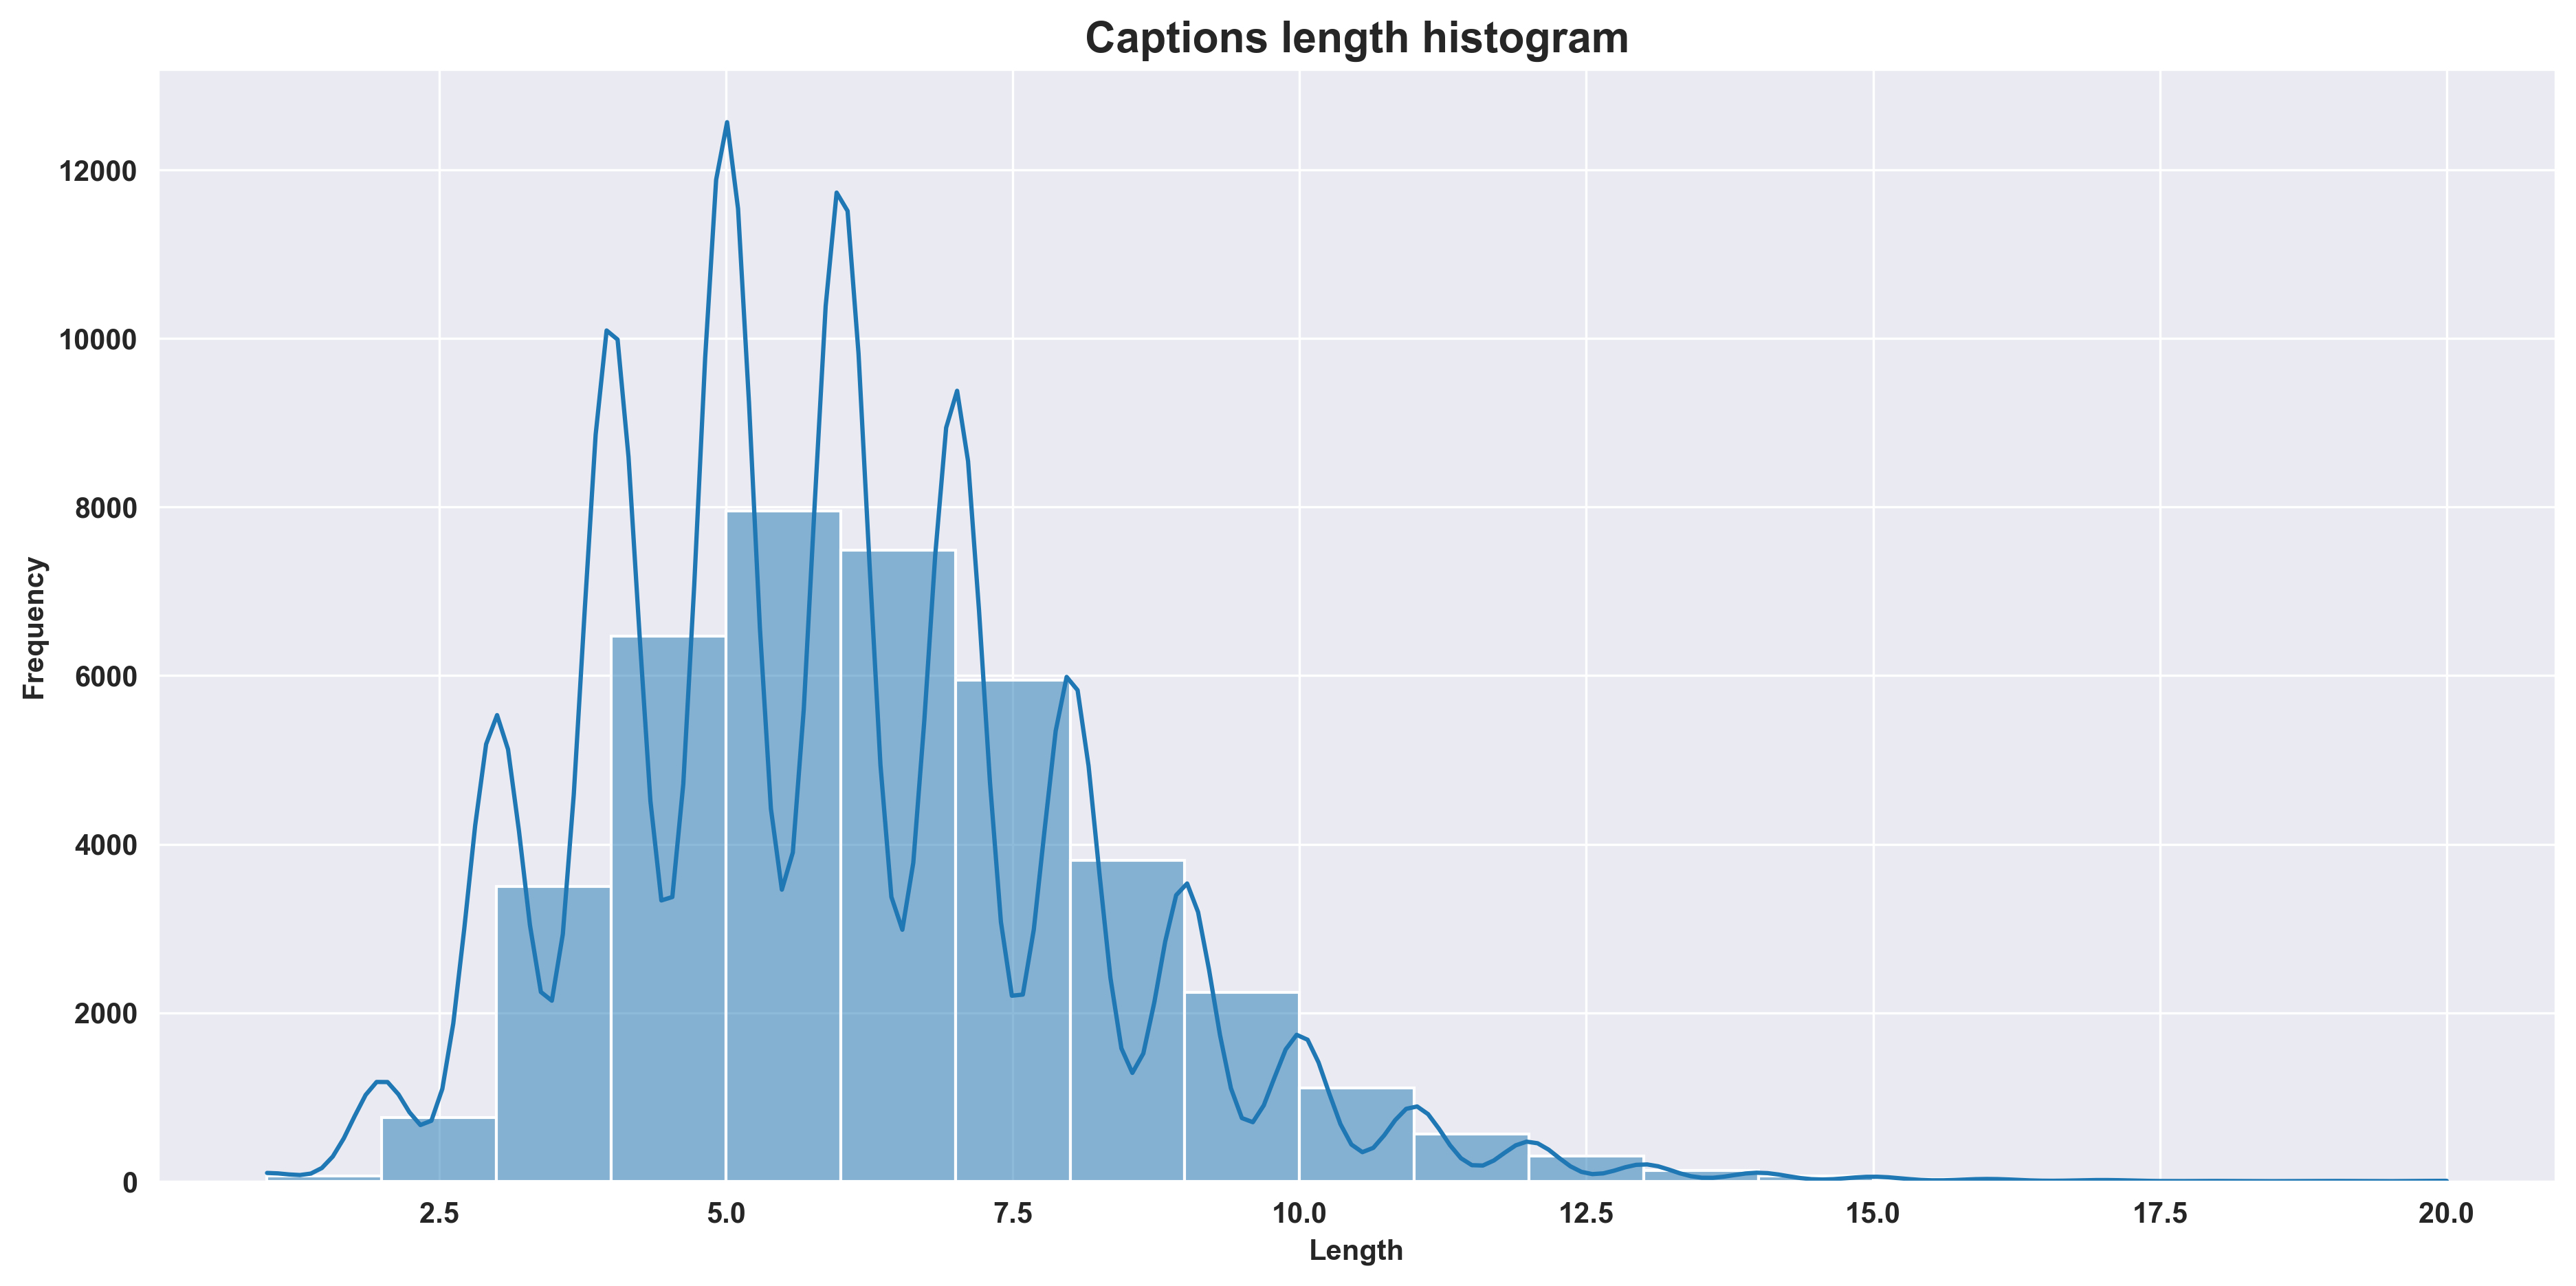

In [36]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Frequency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)

In [37]:
def captions_length(data):
    lengths = [len(x.split()) for x in data]

    plt.figure(figsize=(14, 6))
    sns.set_style("darkgrid")

    sns.histplot(lengths, kde=True, bins=15, color="steelblue", edgecolor="black")

    plt.title("Caption Length Distribution", fontsize=16, fontweight="bold")
    plt.xlabel("Caption Length (words)", fontweight="bold")
    plt.ylabel("Frequency", fontweight="bold")

    plt.show()   


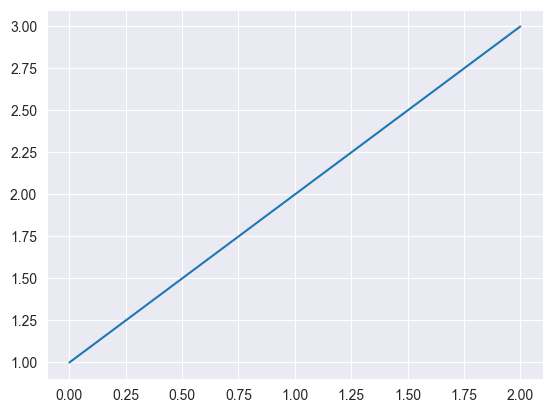

In [38]:
%matplotlib inline
plt.plot([1,2,3])
plt.show()


In [39]:
print(len(cleaned_captions))
print(cleaned_captions[:5])


40455
['child pink dress climbing set stair entry way', 'girl going wooden building', 'little girl climbing wooden playhouse', 'little girl climbing stair playhouse', 'little girl pink dress going wooden cabin']


In [40]:
print([x for x in cleaned_captions[:10]])


['child pink dress climbing set stair entry way', 'girl going wooden building', 'little girl climbing wooden playhouse', 'little girl climbing stair playhouse', 'little girl pink dress going wooden cabin', 'black dog spotted dog fighting', 'black dog tricolored dog playing road', 'black dog white dog brown spot staring street', 'dog different breed looking road', 'dog pavement moving toward']


In [41]:
print("Total captions:", len(cleaned_captions))
print("First caption:", cleaned_captions[0])
print("Lengths sample:", [len(x.split()) for x in cleaned_captions[:10]])


Total captions: 40455
First caption: child pink dress climbing set stair entry way
Lengths sample: [8, 4, 5, 5, 7, 5, 6, 8, 5, 4]


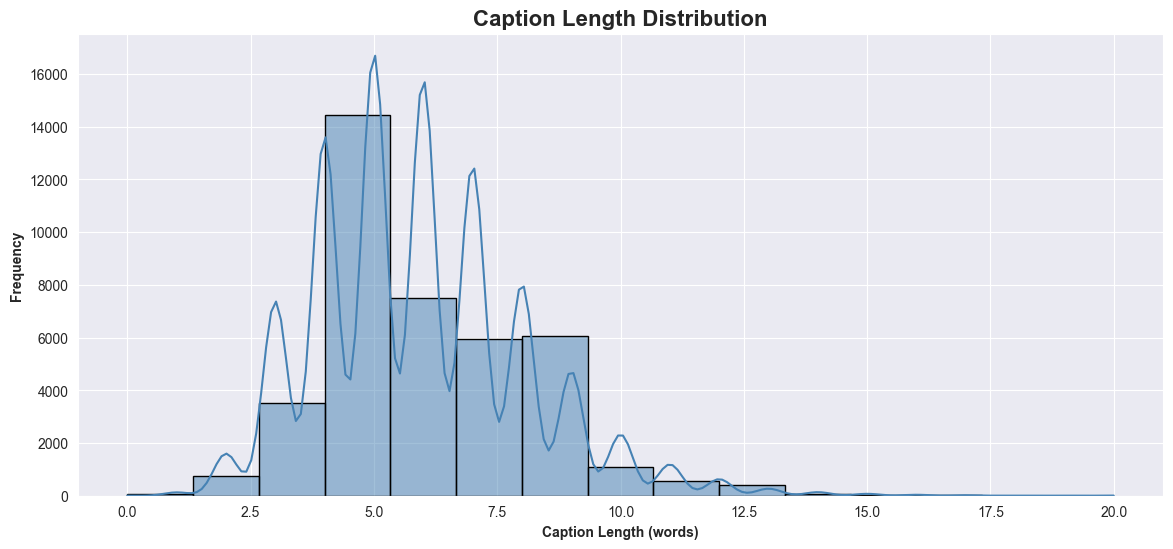

In [42]:
%matplotlib inline
captions_length(cleaned_captions)


In [43]:
max(len(x.split()) for x in cleaned_captions)


20

VOCABULARY TOKENISING

In [44]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7342

In [45]:
import os
from sklearn.model_selection import train_test_split

# --- user paths ---
images_directory = r"C:\Users\newsu\OneDrive\Documents\Images_data"

valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff'}

def list_image_files(dirpath):
    files = []
    for f in os.listdir(dirpath):
        full = os.path.join(dirpath, f)
        if os.path.isfile(full) and os.path.splitext(f.lower())[1] in valid_exts:
            files.append(f)
    return files

all_image_ids = list_image_files(images_directory)   # filenames with extension


def normalize_caption_image_id(raw_id):
    raw = raw_id.strip()
    if '#' in raw:
        raw = raw.split('#')[0]
    raw = os.path.basename(raw)
    return raw

# build mapping
image_to_captions = {}
for line in captions_IDs:
    if not line or not line.strip():
        continue
    parts = line.strip().split('\t', 1)
    if len(parts) == 1:
        parts = line.strip().split(None, 1)
        if len(parts) == 1:
            image_part = parts[0]
            caption_text = ""
        else:
            image_part, caption_text = parts
    else:
        image_part, caption_text = parts

    image_id = normalize_caption_image_id(image_part)
    caption_text = caption_text.strip()

    image_to_captions.setdefault(image_id, []).append(caption_text)

image_files_set = set(all_image_ids)
caption_image_ids_set = set(image_to_captions.keys())

missing_in_folder = sorted([x for x in caption_image_ids_set if x not in image_files_set])
if missing_in_folder:
    print(f"Warning: {len(missing_in_folder)} image ids from captions not found in images folder. Example(s): {missing_in_folder[:5]}")

usable_image_ids = sorted([img for img in all_image_ids if img in image_to_captions])
print(f"Usable images (present in both captions and folder): {len(usable_image_ids)}")

train_ids, temp_ids = train_test_split(usable_image_ids, test_size=0.25, random_state=42)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.4, random_state=42)


train_set, val_set, test_set = set(train_ids), set(val_ids), set(test_ids)

train_captions, val_captions, test_captions = [], [], []
unknown = []
for img_id, caps in image_to_captions.items():
    if img_id in train_set:
        train_captions.extend([f"{img_id}\t{c}" for c in caps])
    elif img_id in val_set:
        val_captions.extend([f"{img_id}\t{c}" for c in caps])
    elif img_id in test_set:
        test_captions.extend([f"{img_id}\t{c}" for c in caps])
    else:
        unknown.append(img_id)

if unknown:
    print(f"Unknown image IDs (not used in any split): {len(unknown)} -- example: {unknown[:5]}")

print("Counts (images):", "train", len(train_ids), "val", len(val_ids), "test", len(test_ids))
print("Counts (caption lines):", "train", len(train_captions), "val", len(val_captions), "test", len(test_captions))

def avg_caps_per_img(captions_list, id_set):
    return len(captions_list) / max(1, len(id_set))

print("Avg captions per image (approx):",
    "train", avg_caps_per_img(train_captions, train_set),
    "val", avg_caps_per_img(val_captions, val_set),
    "test", avg_caps_per_img(test_captions, test_set))


Usable images (present in both captions and folder): 8091
Counts (images): train 6068 val 1213 test 810
Counts (caption lines): train 30340 val 6065 test 4050
Avg captions per image (approx): train 5.0 val 5.0 test 5.0


CNN model from Scratch

In [46]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.models import Model

def build_scratch_cnn(input_shape=(299, 299, 3)):
    inputs = Input(shape=input_shape)

    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)

    x = Flatten()(x)
    outputs = Dense(2048, activation='relu')(x)

    model = Model(inputs, outputs)
    return model


Preprocess Image Manually (No Inception Preprocessing)

In [47]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image_from_scratch(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img) / 255.0     # normalize manually
    img = np.expand_dims(img, axis=0)   # (1, 299, 299, 3)
    return img


Extract Features Using the Scratch CNN

In [48]:
def extract_features_scratch(model, image_path):
    img = preprocess_image_from_scratch(image_path)
    features = model.predict(img, verbose=0)
    return features.flatten()    # flatten to shape (2048,)


Build Your Model and Use It

In [49]:
import os
from pathlib import Path
from tqdm import tqdm
import pickle
import numpy as np
import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
images_directory = Path(r"C:\Users\newsu\OneDrive\Documents\Images_data")
features_out_path = images_directory / "image_features.pkl"
features_out_path.parent.mkdir(parents=True, exist_ok=True)
TEMP_SAVE_INTERVAL = 200
valid_exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}

# --- Resume or start fresh ---
if features_out_path.exists():
    logging.info(f"Found existing features file: {features_out_path}. Resuming.")
    with open(features_out_path, 'rb') as f:
        image_features = pickle.load(f)
else:
    image_features = {}

# --- Ensure model exists: try to use existing scratch_cnn or build it ---
if 'scratch_cnn' not in globals():
    try:
        # This will call your function that builds the model.
        scratch_cnn = build_scratch_cnn()
        logging.info("Built scratch_cnn via build_scratch_cnn().")
    except NameError:
        raise RuntimeError("build_scratch_cnn() is not defined in this environment. "
        "Define or import it, then re-run this cell.")
    except Exception as e:
        raise RuntimeError(f"Error while building scratch_cnn: {e}")

# --- Ensure extractor exists ---
if 'extract_features_scratch' not in globals():
    raise RuntimeError("extract_features_scratch() is not defined. Define or import it.")

# --- Put model in eval / inference mode if applicable ---
# PyTorch-style:
try:
    import torch
    if hasattr(scratch_cnn, "eval"):
        scratch_cnn.eval()
        logging.info("Set PyTorch model to eval() mode.")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    try:
        scratch_cnn.to(device)
        logging.info(f"Moved model to device {device}.")
    except Exception:
        pass
    USE_TORCH = True
except Exception:
    USE_TORCH = False

# TensorFlow/Keras-style: ensure training=False when called inside extractor or call model.predict
USE_TF = False
try:
    # lazy import tensorflow only if needed
    import tensorflow as tf
    USE_TF = True
except Exception:
    pass

# --- Collect image files from folder ---
all_image_paths = [p for p in images_directory.iterdir()
    if p.is_file() and p.suffix.lower() in valid_exts]
logging.info(f"Discovered {len(all_image_paths)} image files in {images_directory}")

count = 0
for img_path in tqdm(all_image_paths, desc="Extracting image features"):
    img_id = img_path.name

    # skip already-computed entries (resume)
    if img_id in image_features:
        continue

    try:
        # If PyTorch, call extractor under torch.no_grad() and ensure tensors on device
        if USE_TORCH:
            with torch.no_grad():
                features = extract_features_scratch(scratch_cnn, str(img_path))
        else:
            # otherwise just call extractor (TF/Keras should handle training=False inside)
            features = extract_features_scratch(scratch_cnn, str(img_path))

        if features is None:
            logging.warning(f"{img_id}: extractor returned None — skipping")
            continue

        # Convert torch tensor to numpy if needed
        if USE_TORCH and hasattr(features, "cpu") and hasattr(features, "numpy"):
            features = features.cpu().detach().numpy()
        elif hasattr(features, "numpy") and not isinstance(features, np.ndarray):
            features = features.numpy()
        features = np.asarray(features)

        image_features[img_id] = features
        count += 1

    except Exception as e:
        logging.exception(f"Error processing {img_id}: {e}")
        # continue to next image

    # periodic checkpoint
    if count and count % TEMP_SAVE_INTERVAL == 0:
        logging.info(f"Saving checkpoint with {len(image_features)} features...")
        with open(features_out_path, 'wb') as f:
            pickle.dump(image_features, f)

# final save
with open(features_out_path, 'wb') as f:
    pickle.dump(image_features, f)

logging.info(f"Done. Extracted features for {len(image_features)} images. Saved to {features_out_path}")


2025-11-23 20:14:08,758 INFO Found existing features file: C:\Users\newsu\OneDrive\Documents\Images_data\image_features.pkl. Resuming.
2025-11-23 20:14:09,706 INFO Built scratch_cnn via build_scratch_cnn().
2025-11-23 20:14:13,229 INFO Discovered 8091 image files in C:\Users\newsu\OneDrive\Documents\Images_data
Extracting image features: 100%|██████████| 8091/8091 [00:00<00:00, 1379909.47it/s]
2025-11-23 20:14:13,461 INFO Done. Extracted features for 8091 images. Saved to C:\Users\newsu\OneDrive\Documents\Images_data\image_features.pkl


Save features to a file

In [50]:
import pickle

with open("scratch_image_features.pkl", "wb") as f:
    pickle.dump(image_features, f)

print("Saved feature vectors for all images!")


Saved feature vectors for all images!


Function to extract features for a LIST of images

In [51]:
def extract_features_for_list(model, image_ids, images_directory):
    features_dict = {}

    for img_id in tqdm(image_ids, desc="Extracting"):
        img_path = os.path.join(images_directory, img_id)
        try:
            features = extract_features_scratch(model, img_path)
            features_dict[img_id] = features
        except:
            print("Error with:", img_id)

    return features_dict


Extract features for TRAIN, VAL, TEST

In [52]:
images_directory = r"C:\Users\newsu\OneDrive\Documents\Images_data"

# use the lists defined earlier (train_ids, val_ids, test_ids)
train_features = extract_features_for_list(scratch_cnn, train_ids, images_directory)
val_features   = extract_features_for_list(scratch_cnn, val_ids, images_directory)
test_features  = extract_features_for_list(scratch_cnn, test_ids, images_directory) 

Extracting: 100%|██████████| 810/810 [02:06<00:00,  6.39it/s]


Saving train,validation and test features into the files

In [53]:
import pickle
from pathlib import Path

save_dir = Path(r"C:\Users\newsu\OneDrive\Documents\Images_data")
save_dir.mkdir(parents=True, exist_ok=True)

train_path = save_dir / "train_features_scratch.pkl"
val_path   = save_dir / "val_features_scratch.pkl"
test_path  = save_dir / "test_features_scratch.pkl"

with open(train_path, "wb") as f:
    pickle.dump(train_features, f)

with open(val_path, "wb") as f:
    pickle.dump(val_features, f)

with open(test_path, "wb") as f:
    pickle.dump(test_features, f)

print("Saved to:")
print(f" - {train_path}")
print(f" - {val_path}")
print(f" - {test_path}")


Saved to:
 - C:\Users\newsu\OneDrive\Documents\Images_data\train_features_scratch.pkl
 - C:\Users\newsu\OneDrive\Documents\Images_data\val_features_scratch.pkl
 - C:\Users\newsu\OneDrive\Documents\Images_data\test_features_scratch.pkl


In [54]:
# Build all captions list from the parsed captions_IDs
all_captions = []

for cap_line in captions_IDs:
    parts = cap_line.split('\t', 1)
    if len(parts) == 2:
        caption = parts[1].strip()
        all_captions.append(caption)

# Convert to sequences
sequences = tokenizer.texts_to_sequences(all_captions)

# Compute maximum length
max_length = max(len(s) for s in sequences)

print("Total captions:", len(all_captions))
print("Max caption length:", max_length)


Total captions: 40455
Max caption length: 22


In [55]:
vocab_size = len(tokenizer.word_index) + 1


In [71]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield [np.array(X_images), np.array(X_captions)], np.array(y)


max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Use scratch CNN output dimension (2048 from your model)
cnn_output_dim = 4096

batch_size_train = 270
batch_size_val = 150

train_data_generator = data_generator(train_captions, train_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_features, tokenizer, max_caption_length, batch_size_val)


## Data Model

Defaulting to user installation because normal site-packages is not writeable


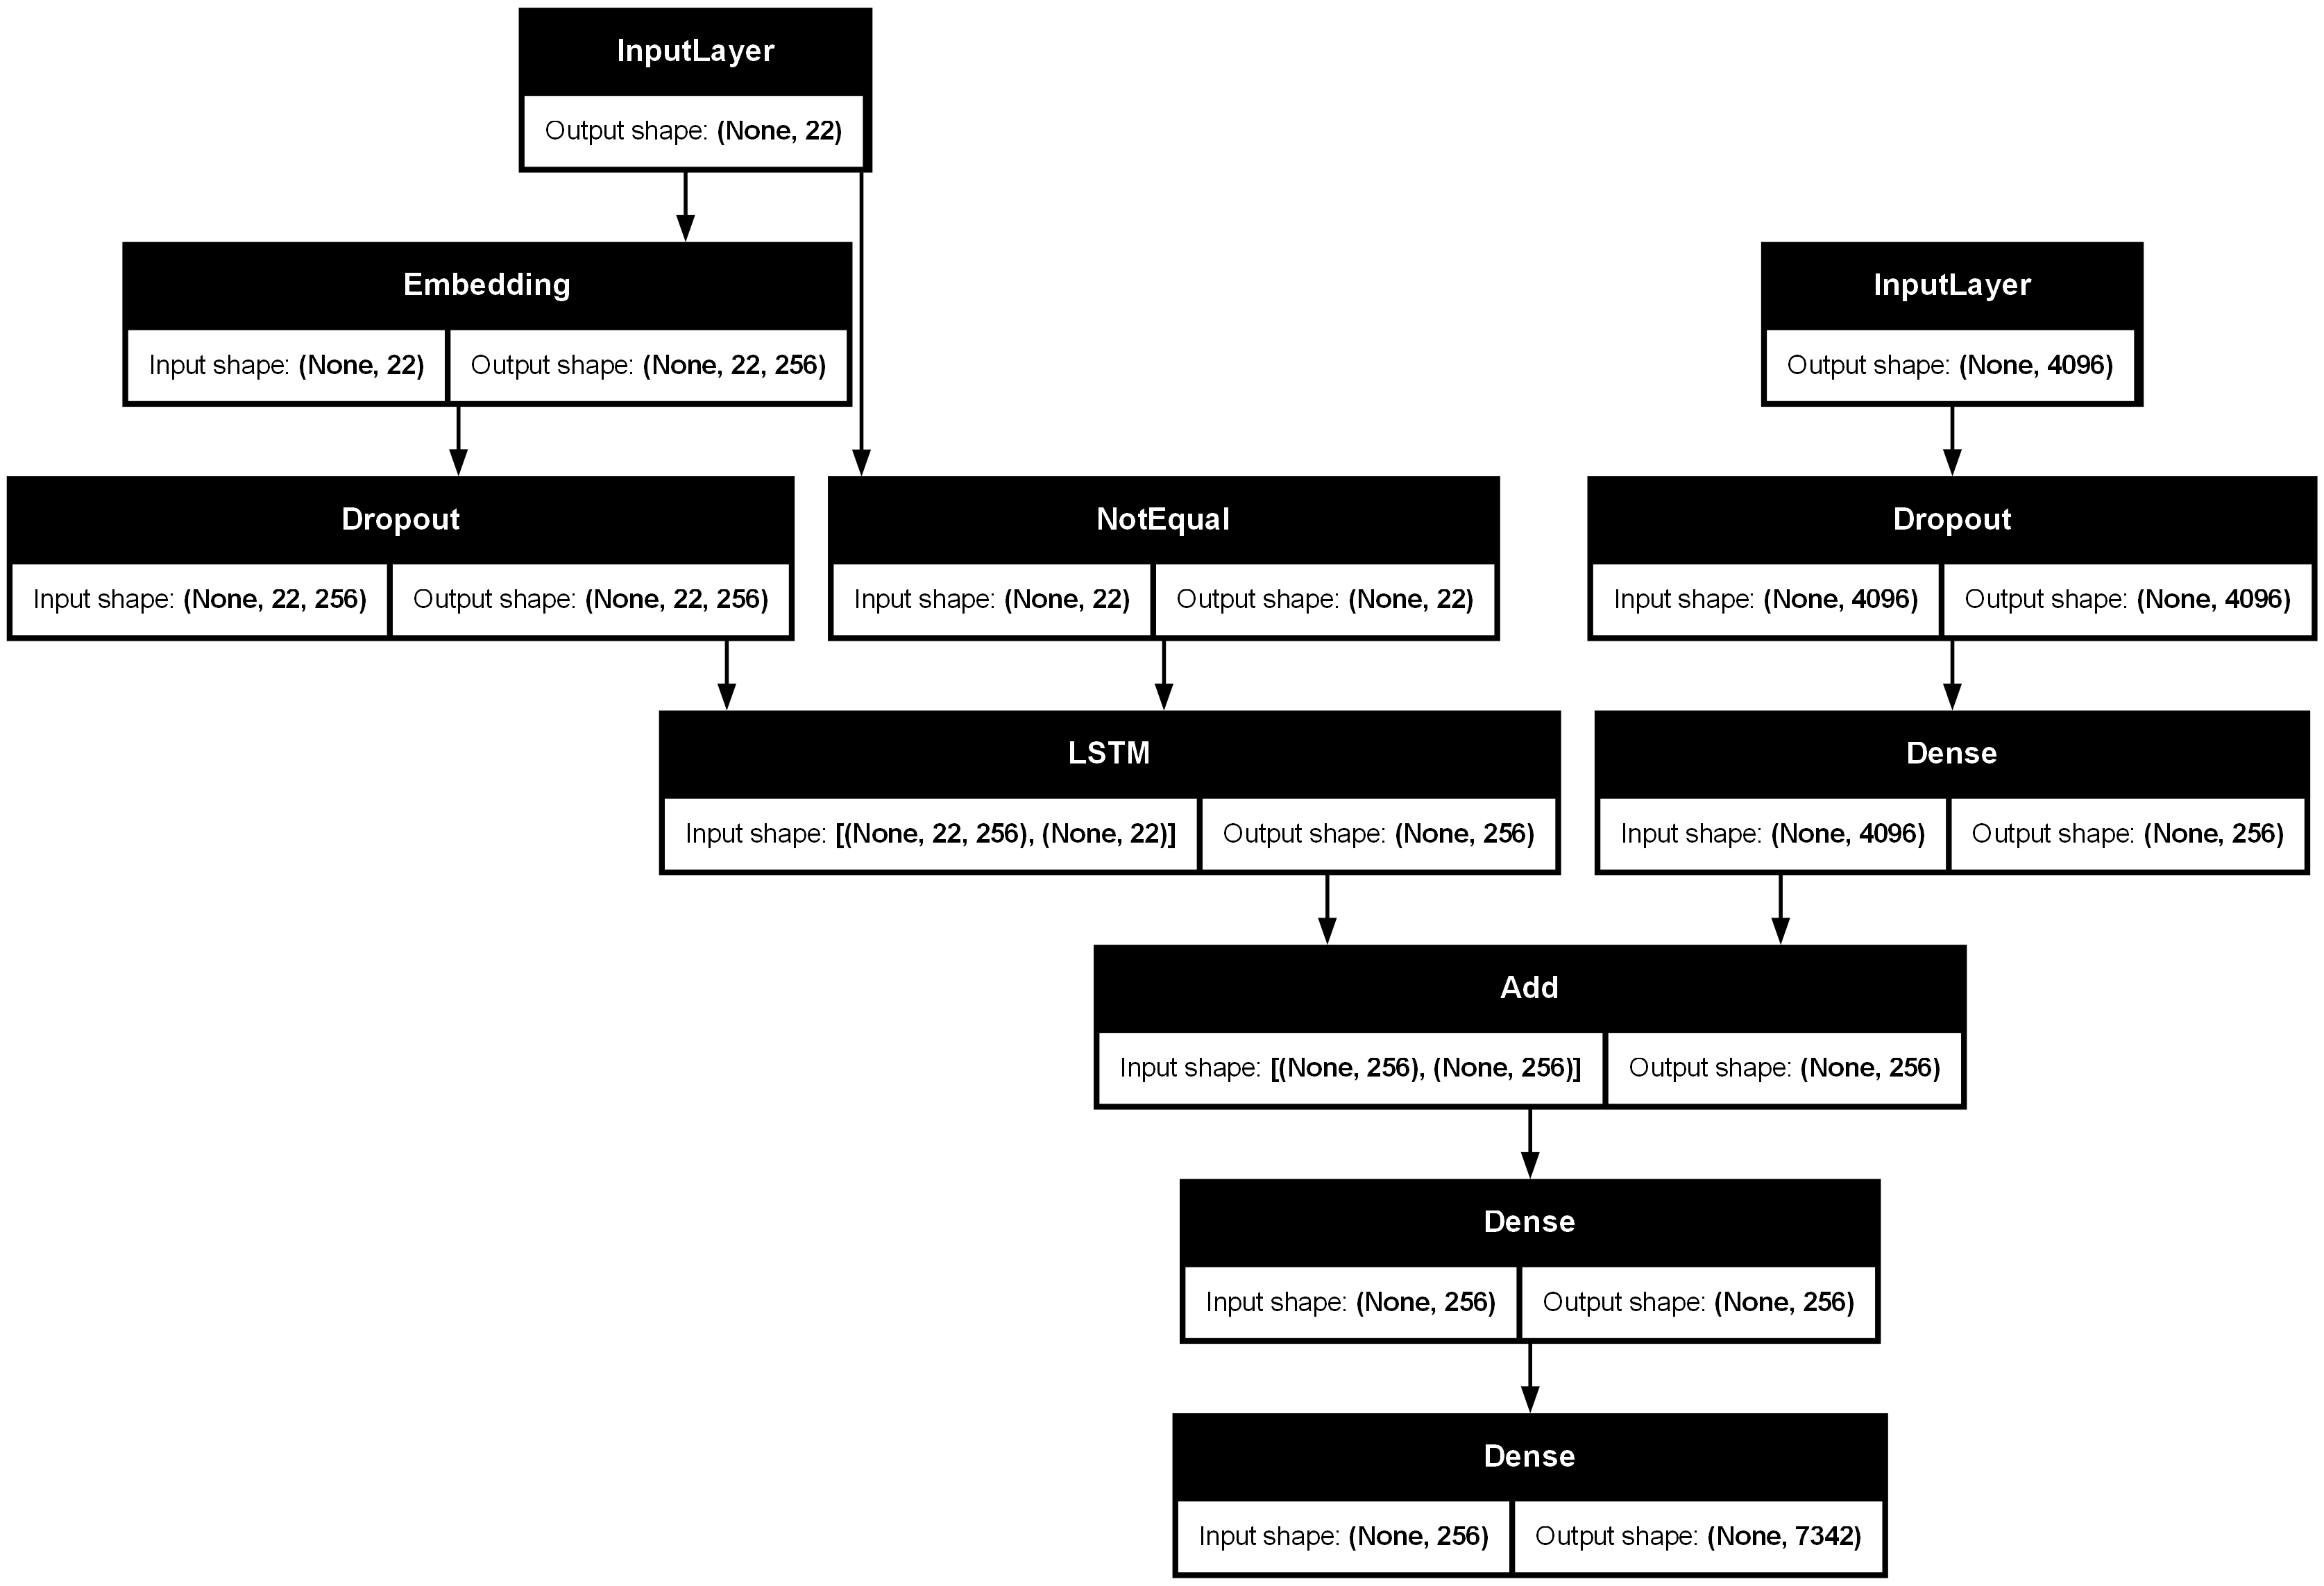

In [72]:
!pip install pydot
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, LSTM, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# 1) Image feature branch (4096-dim from CNN)
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# 2) Text sequence branch
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# 3) Decoder (merge both modalities)
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot model
plot_model(model, show_shapes=True)


In [73]:
for k in image_features:
    image_features[k] = np.pad(image_features[k], (0, 4096 - len(image_features[k])))


In [74]:
print(next(iter(image_features.values())).shape)


(4096,)


In [76]:
max_caption_length = 22


In [77]:
# quick fix cell — force padding to length 22 and rebuild generators
import numpy as np

# 1) force the caption length the model expects
max_caption_length = 22
max_length = 22  # keep both names consistent if used elsewhere

# 2) pick available variables (your notebook may use different names)
caps_train = globals().get('train_captions', globals().get('train_captions', globals().get('captions_IDs', globals().get('captions'))))
caps_val   = globals().get('val_captions', [])
# features used in your notebook: prefer train_features/val_features else image_features
train_feats = globals().get('train_features', globals().get('image_features'))
val_feats   = globals().get('val_features', globals().get('image_features'))
tok = globals().get('tokenizer')
batch_train = globals().get('batch_size_train', globals().get('BATCH_SIZE', 270))
batch_val   = globals().get('batch_size_val', globals().get('BATCH_SIZE', 150))
vocab_sz = globals().get('vocab_size', (len(tok.word_index) + 1) if tok else None)

if tok is None or vocab_sz is None:
    raise RuntimeError("tokenizer (and therefore vocab_size) must be defined before rebuilding generators.")

# 3) if you use the original data_generator function (name = data_generator), use it; 
#    otherwise fall back to build_safe_generator if you added it earlier.
if 'data_generator' in globals():
    train_data_generator = data_generator(caps_train, train_feats, tok, max_caption_length, batch_train)
    val_data_generator   = data_generator(caps_val,   val_feats,   tok, max_caption_length, batch_val)
else:
    # assumes build_safe_generator() from the patch was defined earlier
    train_data_generator = build_safe_generator(caps_train, train_feats, tok, batch_train,
                                                vocab_size=vocab_sz, max_caption_length=max_caption_length,
                                                model_expected_feat_dim=int(globals().get('caption_model', globals().get('model')).input[0].shape[1]))
    val_data_generator = build_safe_generator(caps_val, val_feats, tok, batch_val,
    vocab_size=vocab_sz, max_caption_length=max_caption_length,
    model_expected_feat_dim=int(globals().get('caption_model', globals().get('model')).input[0].shape[1]))

# 4) sanity-check one batch (must show second dimension == 22)
batch = next(train_data_generator)
X_img, X_seq = batch[0]
y = batch[1]
print("Shapes -> images:", X_img.shape, "seqs:", X_seq.shape, "labels:", y.shape)
print("Check seq length (must be 22):", X_seq.shape[1])
print("Nonzero counts img/seq/y:", np.count_nonzero(X_img), np.count_nonzero(X_seq), np.count_nonzero(y))

# 5) Re-run your training cell (use caption_model.fit(...) as before).


Shapes -> images: (1894, 4096) seqs: (1894, 22) labels: (1894, 7342)
Check seq length (must be 22): 22
Nonzero counts img/seq/y: 1989192 8123 1894


In [78]:
train_data_generator = data_generator(train_captions, train_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator   = data_generator(val_captions,   val_features,   tokenizer, max_caption_length, batch_size_val)


In [79]:
from tensorflow.keras.utils import Sequence
import math

class GeneratorSequence(Sequence):
    """Wrap a Python generator (infinite) so Keras can call __getitem__ safely."""
    def __init__(self, gen, steps_per_epoch):
        self._gen = gen             # the generator object (iterator)
        self.steps = int(steps_per_epoch)
        self._iter = iter(self._gen)

    def __len__(self):
        return max(1, self.steps)

    def __getitem__(self, idx):
        # return next batch from the internal iterator; reset on StopIteration
        try:
            batch = next(self._iter)
        except StopIteration:
            self._iter = iter(self._gen)
            batch = next(self._iter)
        # Make sure we return (inputs, targets) as tuples, not lists
        inputs, targets = batch
        # convert input list -> tuple (Keras likes tuple for multi-input)
        if isinstance(inputs, list):
            inputs = tuple(inputs)
        return inputs, targets

# --- Ensure feature vectors match model expected dim (4096) ---
# (Original CNN produced 2048; model built with Input(shape=(4096,)))
target_dim = 4096
def _ensure_dim(dct, target):
    for k, v in dct.items():
        arr = np.asarray(v)
        if arr.shape[0] < target:
            dct[k] = np.pad(arr, (0, target - arr.shape[0]))
        elif arr.shape[0] > target:
            dct[k] = arr[:target]
    return dct

if 'train_features' in globals():
    _ensure_dim(train_features, target_dim)
if 'val_features' in globals():
    _ensure_dim(val_features, target_dim)
if 'test_features' in globals():
    _ensure_dim(test_features, target_dim)

# compute safe step counts
steps_train = max(1, math.ceil(len(train_captions) / batch_size_train))
steps_val   = max(1, math.ceil(len(val_captions)   / batch_size_val))

# Re-create generators with the correct max_length for padding
train_data_generator = data_generator(train_captions, train_features, tokenizer, max_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_features, tokenizer, max_length, batch_size_val)

# wrap your existing generator objects (these are the generator functions/iterators you already built)
train_seq = GeneratorSequence(train_data_generator, steps_train)
val_seq   = GeneratorSequence(val_data_generator, steps_val)

# now call fit using the wrapped Sequences (use the same model variable you already have)
history = globals().get('caption_model', globals().get('model')).fit(
    train_seq,
    steps_per_epoch=steps_train,
    validation_data=val_seq,
    validation_steps=steps_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - loss: 6.2787 - val_loss: 5.5984 - learning_rate: 5.4881e-04
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - loss: 5.4934 - val_loss: 5.4314 - learning_rate: 3.0119e-04
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - loss: 5.3525 - val_loss: 5.3618 - learning_rate: 1.6530e-04
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - loss: 5.2856 - val_loss: 5.3305 - learning_rate: 9.0718e-05
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - loss: 5.2513 - val_loss: 5.3157 - learning_rate: 4.9787e-05
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 199s 2s/step - loss: 5.2320 - val_loss: 5.3079 - learning_rate: 2.7324e-05
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - loss: 5.2215 - val_loss: 5.3036 - learning_rate: 1.4996e-05
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - loss: 5.2156 - val_loss: 5.3013 - learning_rate: 8.2297e-06
Epoch 9/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - loss: 5.2123 - val_loss: 

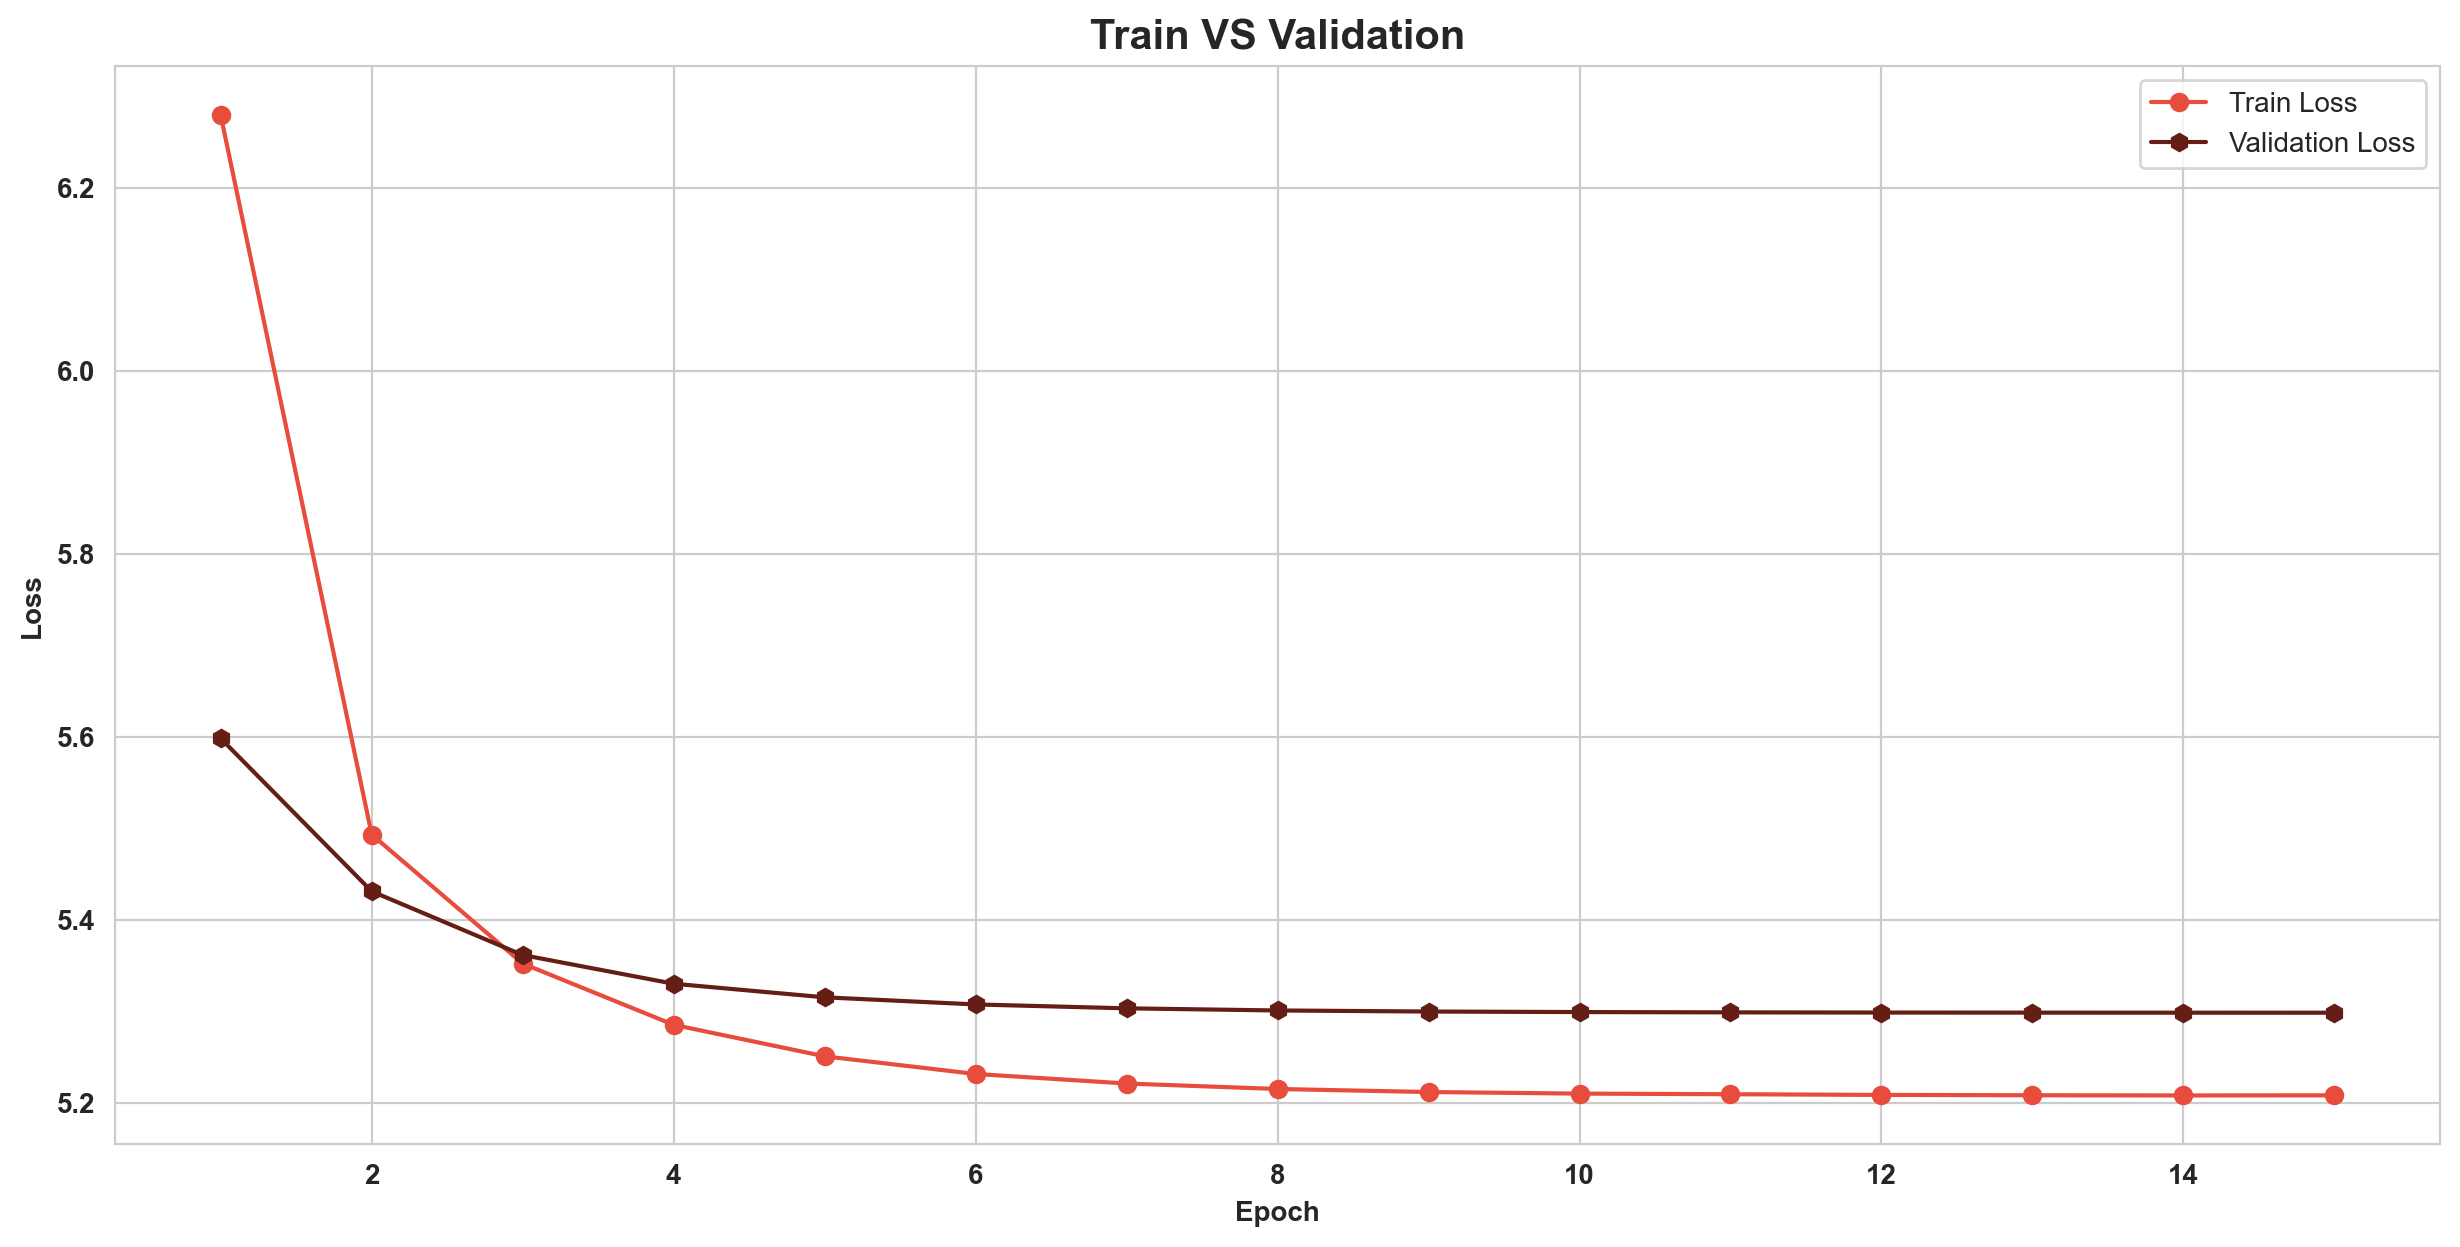

In [80]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [81]:
def beam_search_generator(image_features, K_beams = 3, log = False):
    start = [tokenizer.word_index['start']]
    start_word = [[start, 0.0]]
    for _ in range(max_caption_length):
        temp = []
        for s in start_word:
            sequence  = pad_sequences([s[0]], maxlen=max_caption_length).reshape((1,max_caption_length))
            preds = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
            word_preds = np.argsort(preds[0])[-K_beams:]
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                if log:
                    prob += np.log(preds[0][w]) # assign a probability to each K words
                else:
                    prob += preds[0][w]
                temp.append([next_cap, prob])
                
        start_word = temp
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        start_word = start_word[-K_beams:]

    start_word = start_word[-1][0]
    captions_ = [tokenizer.index_word[i] for i in start_word]
    final_caption = []
    for i in captions_:
        if i != 'end':
            final_caption.append(i)
        else:
            break
        
    final_caption = ' '.join(final_caption[1:])
    return final_caption